Avvio Grid Search...


/tmp/ipython-input-1099095463.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y_raw.replace({'CL0': 0, 'CL1': 0, 'CL2': 1, 'CL3': 1, 'CL4': 1, 'CL5': 1, 'CL6': 1})


Migliori parametri trovati: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Baseline Accuracy (scimmia): 0.60


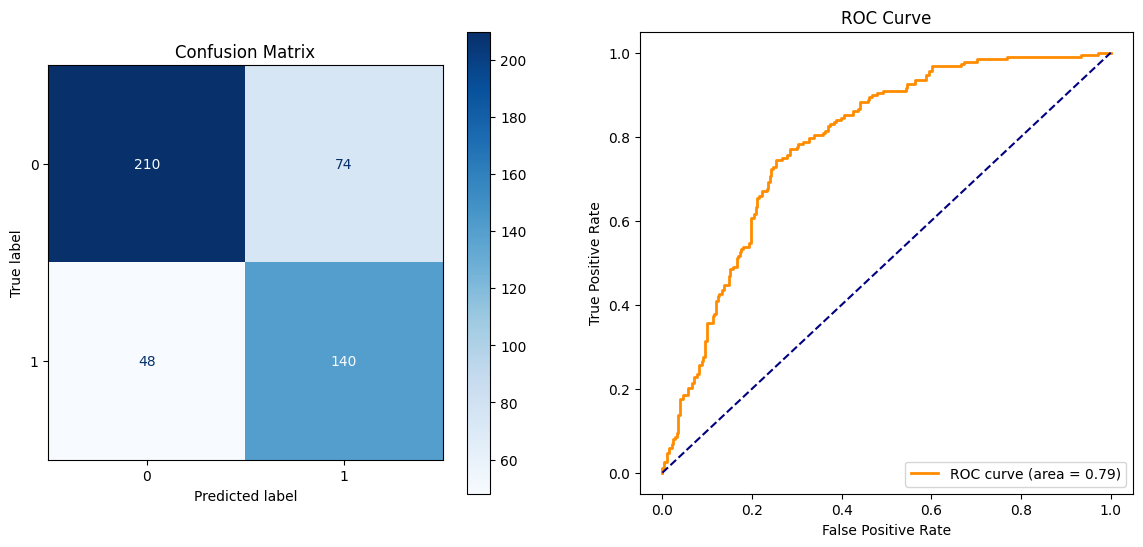

/tmp/ipython-input-1099095463.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


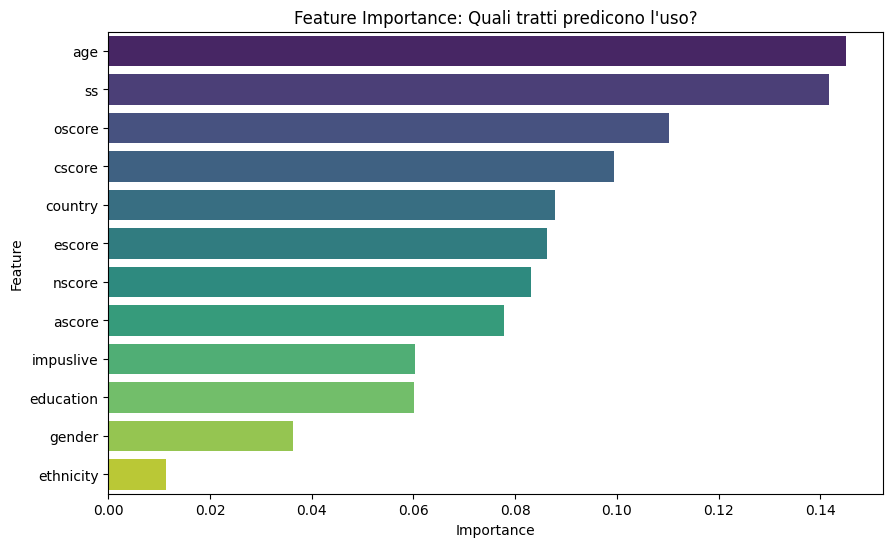


--- REPORT DI CLASSIFICAZIONE ---
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       284
           1       0.65      0.74      0.70       188

    accuracy                           0.74       472
   macro avg       0.73      0.74      0.74       472
weighted avg       0.75      0.74      0.74       472



In [1]:

# SETUP DATI
!pip install ucimlrepo -q
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc

# Scarico il dataset
drug_consumption = fetch_ucirepo(id=373)
X = drug_consumption.data.features
y_raw = drug_consumption.data.targets['ecstasy'] # Target: ecstasy

# Binarizzo il target: 0 = Non User (Mai/Decade fa), 1 = User (Recente)
y = y_raw.replace({'CL0': 0, 'CL1': 0, 'CL2': 1, 'CL3': 1, 'CL4': 1, 'CL5': 1, 'CL6': 1})

# MODELLO E ANALISI

# 1. SPLIT DEI DATI
# Uso stratify=y per assicurarmi che la proporzione User/Non-User sia identica tra train e test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 2. GRID SEARCH (Ricerca Iperparametri)
# Definisco quali combinazioni di parametri testare per trovare la Random Forest migliore
param_grid = {
    'n_estimators': [50, 100, 200],      # Numero alberi
    'max_depth': [None, 10, 20],         # Profondità massima alberi
    'min_samples_split': [2, 5],         # Minimo campioni per splittare un nodo
    'class_weight': ['balanced', None]   # Gestione sbilanciamento classi
}

print("Avvio Grid Search...")
rf = RandomForestClassifier(random_state=42)
# Uso f1-score come metrica perché è più affidabile dell'accuracy se le classi sono sbilanciate
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Migliori parametri trovati: {grid_search.best_params_}")

# 3. BASELINE (Dummy Classifier)
# Creo un modello 'stupido' per vedere se la mia Random Forest fa meglio del caso
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
baseline_score = dummy.score(X_test, y_test)
print(f"Baseline Accuracy (scimmia): {baseline_score:.2f}")

# 4. PREDIZIONI E PROBABILITÀ
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1] # Serve per la curva ROC

# ==========================================
# VISUALIZZAZIONE RISULTATI
# ==========================================

# A. Confusion Matrix e ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Matrice di confusione: per vedere falsi positivi vs falsi negativi
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0], cmap='Blues', normalize=None)
ax[0].set_title("Confusion Matrix")

# Curva ROC: valuta la capacità di distinguere le classi
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc="lower right")

plt.show()

# B. Feature Importance
# Estraggo l'importanza delle features per capire quali tratti psicologici pesano di più
importances = best_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title("Feature Importance: Quali tratti predicono l'uso?")
plt.show()

# C. Report finale testuale
print("\n--- REPORT DI CLASSIFICAZIONE ---")
print(classification_report(y_test, y_pred))